### Portfolio Theory : CAPM
    
- 포트폴리오 수익률 및 표준편차
- Efficient Frontier
- Optimization
- Sharpe Ratio
- Diversification 의 한계

### 프로그래밍 환경 설정
 - 데이터 라이브러리 지정
 - 한글 관련 설정 등

In [1]:
## 사용자 정의 모듈 업데이트시마다 자동 load

%load_ext autoreload
%autoreload 2

## 파이썬 모듈 import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# import numpy_financial as npf

from scipy.stats import norm
from scipy.stats import jarque_bera
from scipy.optimize import minimize
from scipy.optimize import newton
from numpy.linalg import inv
import matplotlib.ticker as ticker
# import seaborn as sns
from datetime import datetime, timedelta
import sys
# from pyxirr import xirr

import yfinance as yf
import ipywidgets as widgets
from IPython.display import display
from functools import partial

## 사용자 정의 모듈 Import

import PM_Tool_Kit_2025 as pk

## 그래프 한글 깨짐 방지

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')  # 예: 'seaborn', 'ggplot', 'fivethirtyeight' 등 사용 가능

#os.chdir('C://Users//youid//Desktop//Jupyter NB')

## 2개 자산(주식,채권)의 Efficient Frontier
- 가장 대표적인 자산배분 전략이 60:40 투자전략 (주식60% / 채권40% 장기투자)
- 자산배분의 성과를 확인하고, Efficient Frontier를 작성

### 들어가기 앞서...듀레이션 별로 채권 ETF의 특성 비교
- 중기채의 경우 20년 평균 수익률 약 3%, 변동성 6% 내외
- 장기채 (20년 이상)의 경우 변동성 14% 수준으로 S&P500의 변동성 17%와 유사



In [2]:
### 채권 ETF의 비교
stdt = '2003-01-01'
ltdt = '2024-12-31'

# SPY : S&P500 ETF
# JPST : 미국채 듀레이션 1년 이하
# SHY : 미국채 만기 1~3년
# IEF : 미국채 만기 7~10년
# TLT : 미국채 만기 20년 이상
# AGG : 회사채 포함 US Aggregate 지수 추종

# Yahoo Finance에서 데이터 입수
bnd_etf = yf.download(['SPY','JPST','AGG','SHY','IEF','TLT'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)

# 야후 파이낸스는 시간에 timezone 이 붙어서 이를 제거
# 분석에는 수정주가를 사용
bnd_etf = bnd_etf.tz_localize(None)['Adj Close']

[*********************100%***********************]  6 of 6 completed


Ticker,AGG,IEF,JPST,SHY,SPY,TLT
Annual_Rtn,0.029795,0.032827,0.026921,0.018041,0.108493,0.034506
Annual_Std,0.051703,0.06523,0.011623,0.013789,0.17257,0.13697
Normal VaR,-0.011203,-0.014217,-0.002139,-0.002799,-0.037091,-0.03041
C-F VaR,-0.008331,-0.014995,0.000478,-0.00245,-0.038671,-0.031027
Historical VaR,-0.009479,-0.014963,-0.000561,-0.002608,-0.035958,-0.031242
MDD,-0.184329,-0.239248,-0.032813,-0.057071,-0.551894,-0.483511
Sharpe,-0.003966,0.04334,-0.264913,-0.867292,0.454848,0.032895


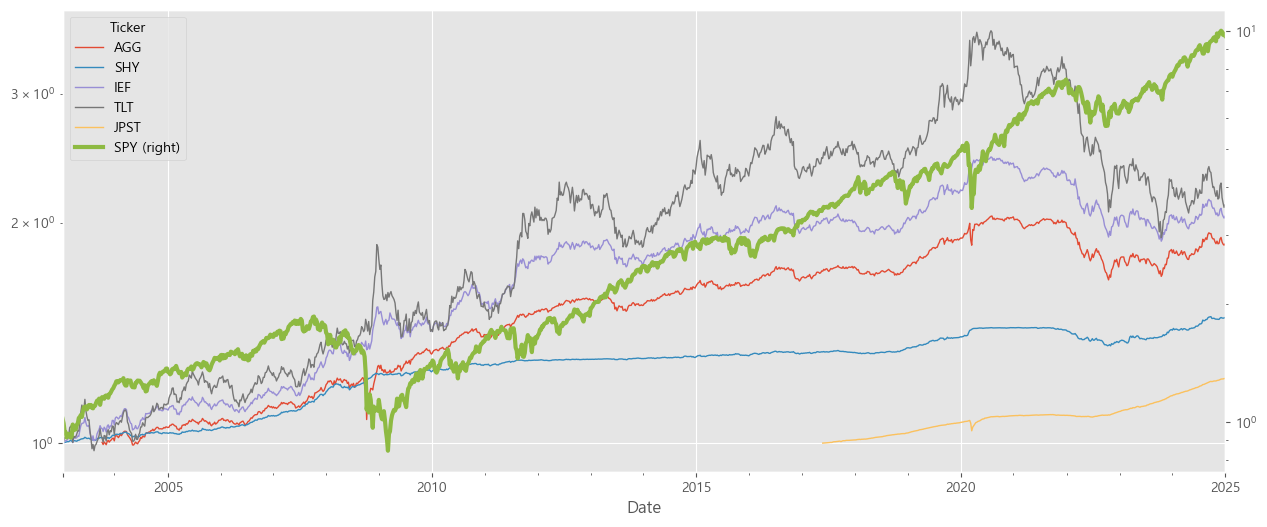

In [3]:
### 그래프 및 요약 통계 작성

# ETF 주가 데이터에서 주간수익률 산출
bnd_r = pk.get_return(bnd_etf,freq = 'W')

# ETF간의 성과 비교를 위해 주간수익률을 누적하여 그래프 그림
# 채권ETF의 성과는 좌축에, 비교를 위해 주식ETF의 성과는 우축에 표시
cum_rtn = (1+bnd_r).cumprod()
ax1 = cum_rtn[['AGG','SHY','IEF','TLT','JPST']].plot(figsize=(15,6),legend = True, linewidth = 1,logy=True);
cum_rtn['SPY'].plot(ax = ax1, legend = True, secondary_y = True, linewidth = 3,logy=True);

# ETF의 성과요약 테이블
desc = pk.fs_desc(bnd_etf,"W",rf = 0.03)
display(desc)


### 주식 - 채권 포트폴리오 및 Efficient Frontier 작성
 - 주식 / 채권의 성과 비교
 - 주식 / 채권의 자산배분 비율에 따른 성과의 변화
 - Efficient Frontier 작성

In [4]:
### 데이터 입수

stdt = '2005-01-01'
ltdt = '2024-12-31'

stk_data = yf.download(['AGG','SPY'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)  
stk_data = stk_data.tz_localize(None)['Adj Close']
stk_data.columns = ['US Bond','US Stock']
stk_data = stk_data[['US Stock','US Bond']]   ## 주식 - 채권 순서로 재배열

[*********************100%***********************]  2 of 2 completed


Portfolio Mean & Volatility



,US Stock,US Bond
Annual_Rtn,10.37%,2.92%
Annual_Std,17.65%,5.25%



Sharpe Ratio



,US Stock,US Bond
Sharpe,0.4176,-0.0155


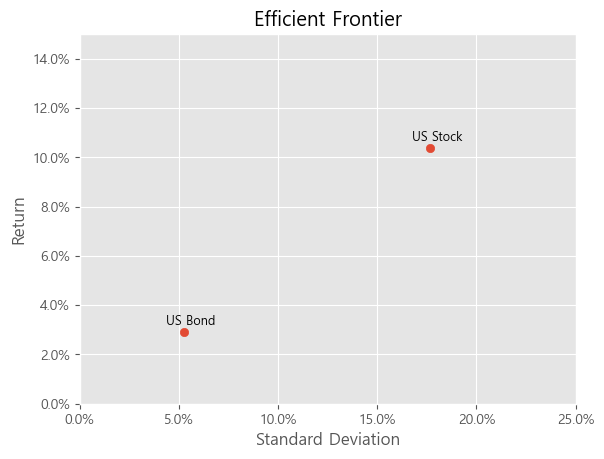

In [5]:
### 주식 / 채권 비교

rf = 0.03   ## Risk-free rate
desc = pk.fs_desc(stk_data,'W',0.03)

print(f'Portfolio Mean & Volatility\n')
display(desc.loc[['Annual_Rtn','Annual_Std']].style.format("{:.2%}"))

print(f'\nSharpe Ratio\n')
display(desc.loc[['Sharpe']].style.format("{:.4f}"))

### 그래프 출력

std_ann = desc.loc['Annual_Std']
rtn_ann = desc.loc['Annual_Rtn']

# 산점도 출력
plt.scatter(std_ann,rtn_ann)
# gca : get current axes (ax: 두개의 축으로 이루어진 그래프가 출력되는 공간)
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.gca().set_xlim(0,0.25);
plt.gca().set_ylim(0,0.15);

# 축 라벨 표시
plt.xlabel('Standard Deviation');
plt.ylabel('Return');
# 그래프 제목 표시
plt.title('Efficient Frontier');

# 산점도에 점을 표시하고 각 점에 제목을 표시
for i in range(0,len(rtn_ann)):
    plt.annotate(rtn_ann.index[i], (std_ann.iloc[i], rtn_ann.iloc[i]), textcoords="offset points", xytext=(5,5), ha='center',fontsize =9);

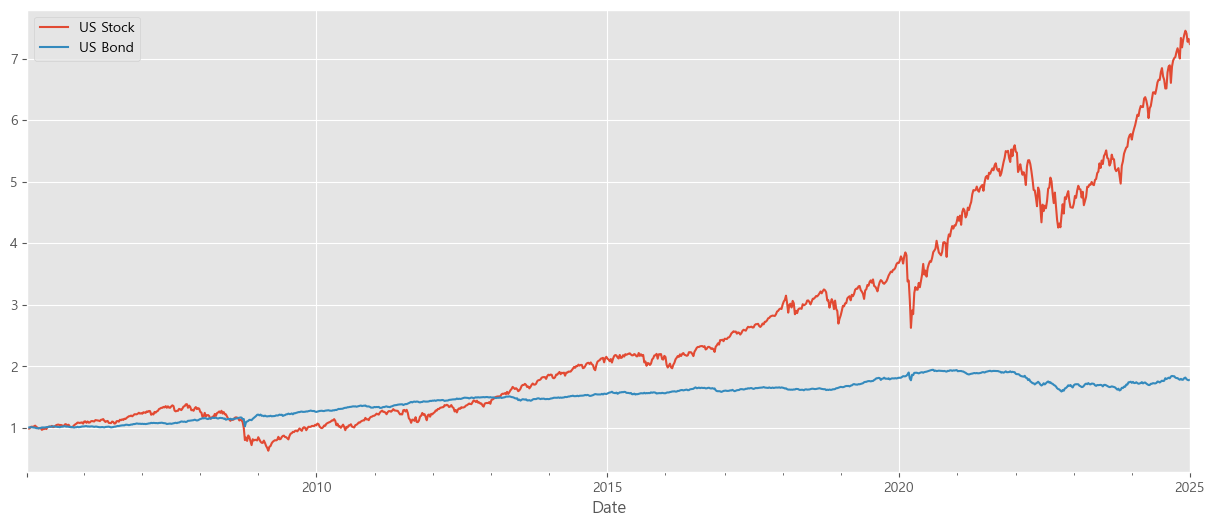

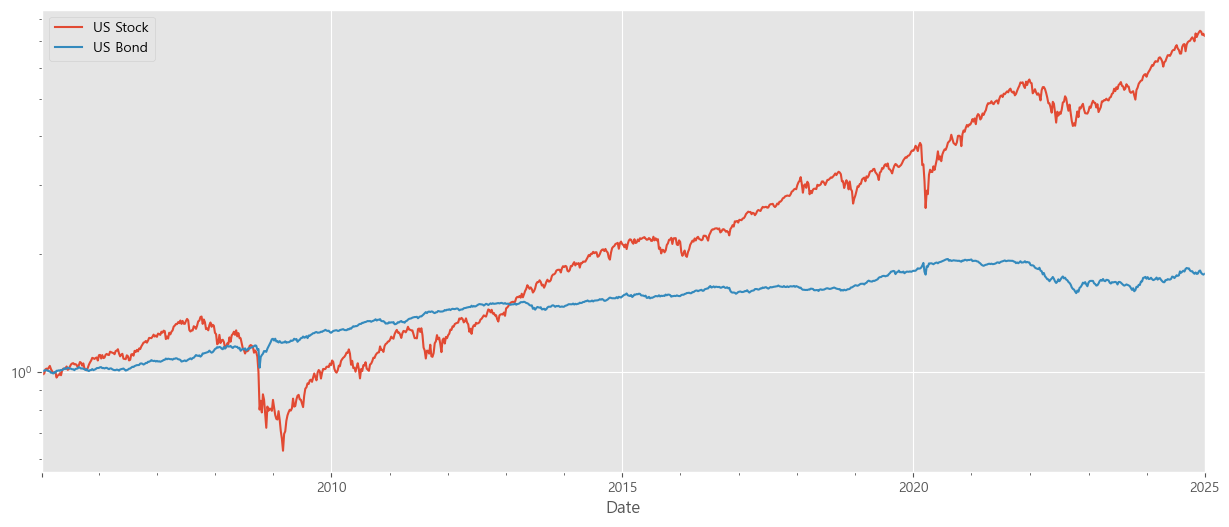

In [6]:
### 누적 수익률 추이
rtn_w = pk.get_return(stk_data,freq = 'W')
cum_rtn = (1+rtn_w).cumprod()
cum_rtn.plot(figsize=(15,6));
cum_rtn.plot(figsize=(15,6),logy=True);

,US Stock,US Bond,Portfolio
Annual_Rtn,0.1039,0.029153,0.054429
Annual_Std,0.176575,0.052517,0.06995
Normal VaR,-0.038071,-0.0114,-0.014888
C-F VaR,-0.039839,-0.008543,-0.012599
Historical VaR,-0.038219,-0.009573,-0.012262
MDD,-0.54613,-0.181742,-0.19952
Sharpe,0.418522,-0.016119,0.349236


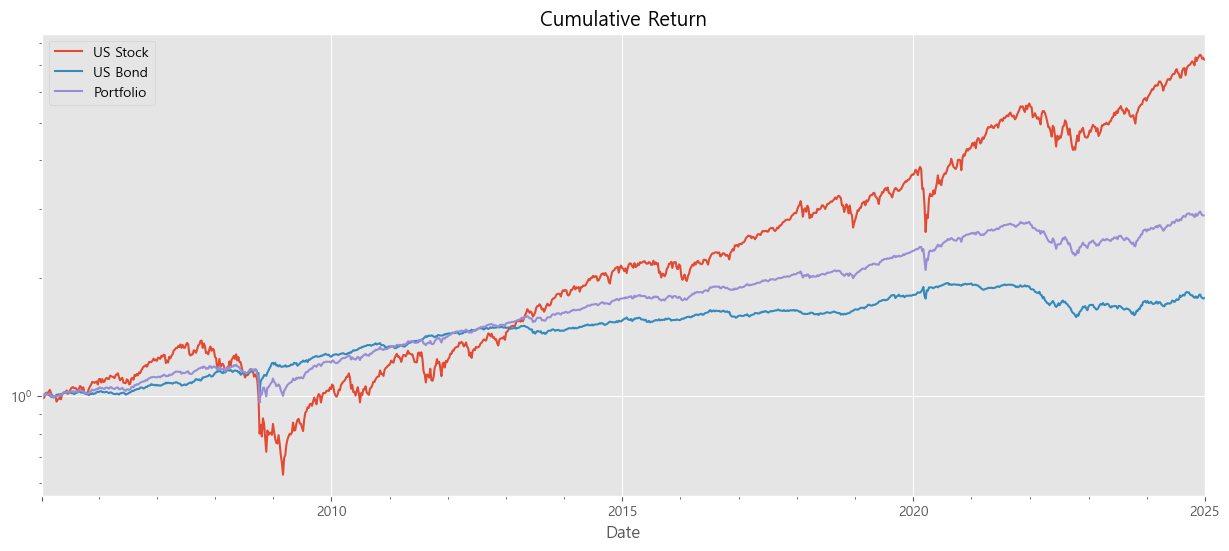

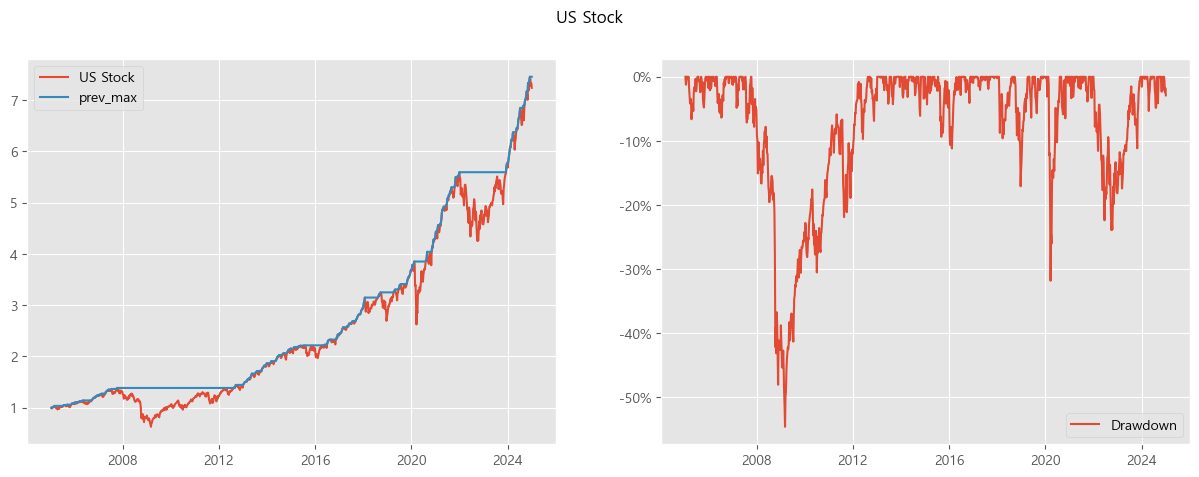

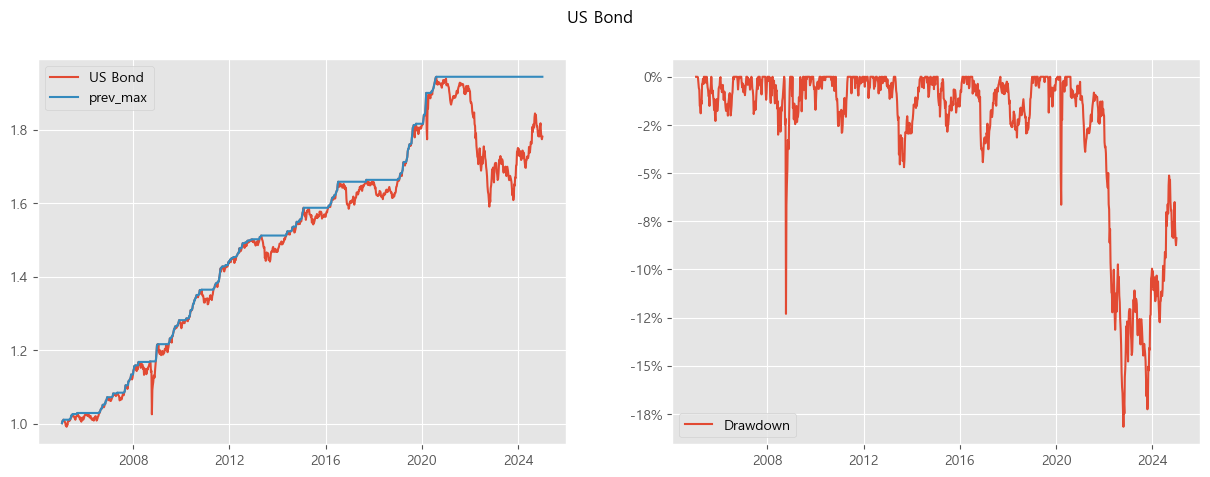

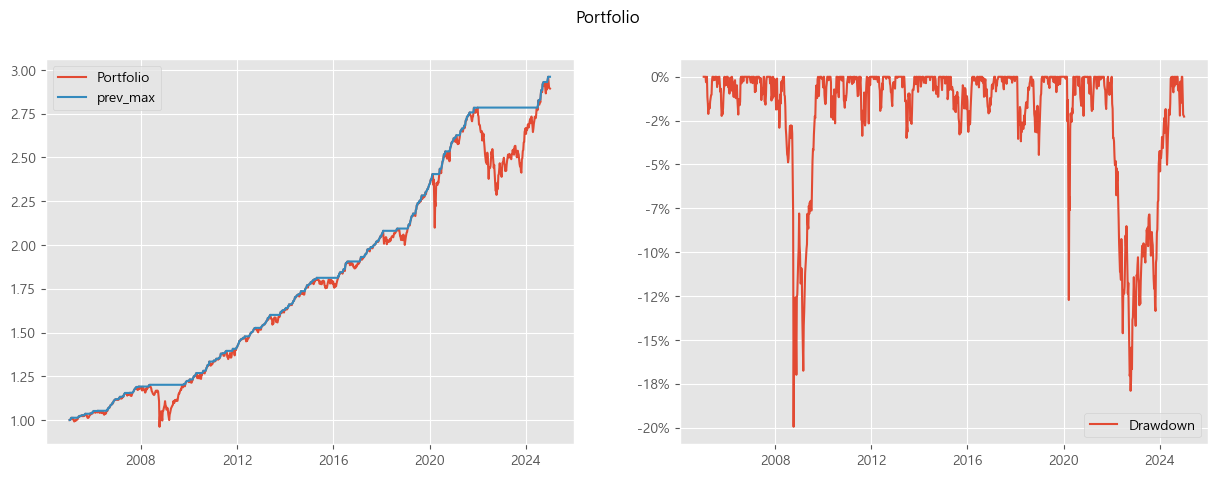

In [7]:
### 포트폴리오

# 주식 / 채권 비중
wgt = [0.3,0.7]

# 포트폴리오 수익률 (실제 포트폴리오 수익률과는 다소 상이)
pf_rtn_w = rtn_w @ wgt

### 주식,채권,포트폴리오 수익률 비교

# 주식/채권 수익률과 포트폴리오 수익률을 하나의 데이터 프레임으로 합침
rtns = pd.concat([rtn_w,pf_rtn_w],axis=1)
rtns.columns = ['US Stock','US Bond','Portfolio']

# 누적성과
cum_rtns = (1+rtns).cumprod()
cum_rtns.plot(figsize=(15,6),logy=True);
plt.title('Cumulative Return');

# 누적성과의 성과 descripton
desc = pk.fs_desc(cum_rtns,'W',0.03)
display(desc)

# MDD 그래프
dd = pk.drawdown(cum_rtns,show_mdd = True)

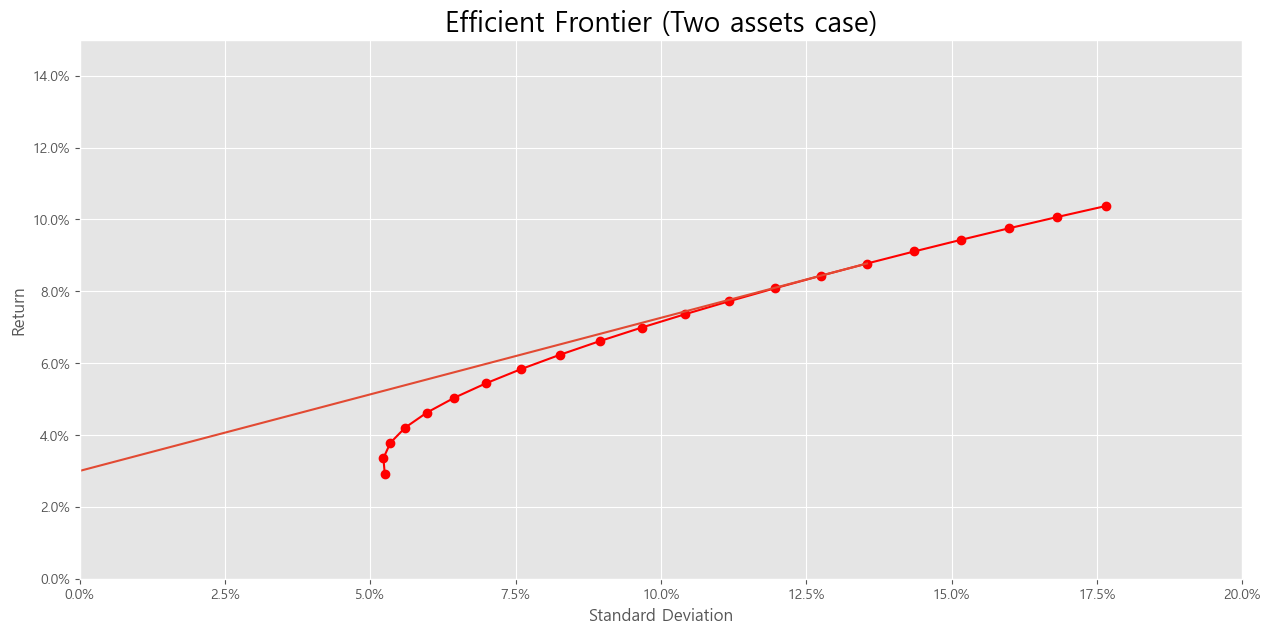

In [8]:
### 주식 - 채권의 Efficient Portfolio

# Efficient Frontier 를 저장할 빈 데이터프레임 정의
ef = pd.DataFrame(columns = ['stock_wgt','rtn','stdev','sharpe'],index = np.arange(0,21))

# 주식비중을 5% 간격으로 20개 정의
ef['stock_wgt'] = np.linspace(0,1,21)

rf = 0.03

# 각 주식비중별로 수익률, 표준편차 및 Sharpe ratio를 산출
for i in range(0,len(ef)):
    wgt = [ef['stock_wgt'].iloc[i],1-ef['stock_wgt'].iloc[i]]
    pf_rtn_w = rtn_w @ wgt
    ef.loc[i,'rtn'] = pk.annualize_return(pf_rtn_w,52).iloc[0,0]
    ef.loc[i,'stdev'] = pk.annualize_vol(pf_rtn_w,52).iloc[0,0]
    ef.loc[i,'sharpe'] = (ef['rtn'].iloc[i] - rf) / ef['stdev'].iloc[i]

# 그래프
fig,ax = plt.subplots(1,1,figsize = (15,7))

plt.gca().plot(ef['stdev'],ef['rtn'],c='red',marker = 'o');

plt.gca().set_ylim(0,0.15);
plt.gca().set_xlim(0,0.2);

# Sharpe Ratio가 최대인 점을 찾음
max_sharpe = ef.loc[ef['sharpe'].idxmax()]
max_sharpe_rtn = max_sharpe['rtn']
max_sharpe_std = max_sharpe['stdev']

# Sharpe Ratio가 최대인 점과 rf를 연결
plt.gca().plot([0,max_sharpe_std],[rf,max_sharpe_rtn]);

plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.gca().set_title('Efficient Frontier (Two assets case)', fontsize = 20);
plt.gca().set_xlabel('Standard Deviation');
plt.gca().set_ylabel('Return');



## n개 자산의 Efficient Frontier
 - 2개 자산의 경우에는 한개 자산의 비중이 주어지면 다른 자산의 비중이 자동으로 주어지므로 최적화가 필요 없음
 - 3개 이상의 자산부터는 동일한 수익률에서 분산을 최소화 하는 포트폴리오를 산출하는 과정 필요
 - S&P500지수의 업종수익률 데이터로 실습

In [9]:
### 분석기간
stdt = '2005-01-01'
ltdt = '2024-12-31'

### 데이터 입수
stk_data = yf.download(['^GSPC','^SP500-1010','^SP500-15','^SP500-20','^SP500-25','^SP500-30','^SP500-35','^SP500-40','^SP500-45','^SP500-50','^SP500-55'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)  

stk_data = stk_data.tz_localize(None)['Adj Close']

# 'SP500': s&p500지수,'ENG': 에너지,'MAT': 소재,'IND': 산업재,
# 'CD': Consumer Discretionary,'CS': Consumer Staple,
# 'HLTH': 헬스케어,'FIN': 금융,'TECH': 테크,'COM': 통신,'UTIL': 유틸리티
stk_data.columns = ['SP500','ENG','MAT','IND','CD','CS','HLTH','FIN','TECH','COM','UTIL']
stk_data.head()

[*********************100%***********************]  11 of 11 completed


,SP500,ENG,MAT,IND,CD,CS,HLTH,FIN,TECH,COM,UTIL
Date,,,,,,,,,,,
2005-01-03,1202.079956,279.540009,181.179993,287.510010,277.459991,236.589996,346.809998,409.489990,326.829987,128.679993,139.929993
2005-01-04,1188.050049,277.769989,177.089996,283.510010,274.010010,235.210007,344.250000,405.579987,320.390015,126.849998,138.800003
2005-01-05,1183.739990,276.709991,175.690002,281.910004,272.850006,235.020004,343.149994,404.730011,318.850006,126.970001,137.419998
2005-01-06,1187.890015,281.269989,176.690002,283.260010,271.709991,236.300003,345.619995,406.779999,318.070007,126.559998,137.699997
2005-01-07,1186.189941,279.000000,177.149994,282.059998,271.239990,237.460007,345.720001,404.769989,318.820007,126.389999,137.309998


### 업종별 수익 - 위험 Scatter Diagram 표시

,SP500,ENG,MAT,IND,CD,CS,HLTH,FIN,TECH,COM,UTIL
Annual_Rtn,0.083328,0.042757,0.055948,0.071033,0.100431,0.065801,0.079412,0.034799,0.143049,0.051212,0.052803
Annual_Std,0.17517,0.272773,0.226155,0.20595,0.213964,0.134351,0.162238,0.275093,0.207282,0.192332,0.18219
Normal VaR,-0.038118,-0.060685,-0.050045,-0.045246,-0.046523,-0.029243,-0.03528,-0.061368,-0.044292,-0.042553,-0.040244
C-F VaR,-0.040171,-0.065024,-0.049985,-0.046256,-0.04568,-0.032563,-0.038276,-0.043995,-0.047096,-0.043133,-0.040034
Historical VaR,-0.038116,-0.057981,-0.050292,-0.042496,-0.045417,-0.026695,-0.032639,-0.055735,-0.043614,-0.039727,-0.03785
MDD,-0.567754,-0.755878,-0.621105,-0.651511,-0.605324,-0.348358,-0.407772,-0.839584,-0.550231,-0.513206,-0.491715
Sharpe,0.304439,0.046767,0.114733,0.199239,0.329173,0.266473,0.304561,0.017445,0.545388,0.11029,0.125161


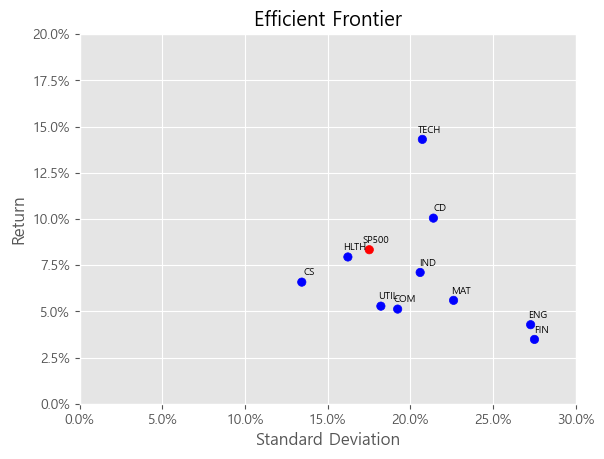

In [10]:
rf = 0.03   ## Risk-free rate
rtn_w = pk.get_return(stk_data,freq = 'W')
cov = rtn_w.cov()

# 업종 데이터의 특성
desc = pk.fs_desc(stk_data,'W',rf)
display(desc)

# 수익률, 표준편차 데이터
rtn_ann = desc.loc['Annual_Rtn']
std_ann = desc.loc['Annual_Std']

### 그래프 출력

# 그래프 상의 각 점별로 색깔 지정 (S&P500 지수만 별도 표시)
colors = ['red','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue']

# 기타 포맷 지정
plt.scatter(std_ann,rtn_ann,c=colors)
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.xlabel('Standard Deviation');
plt.ylabel('Return');
plt.title('Efficient Frontier');
plt.gca().set_xlim(0,0.3);
plt.gca().set_ylim(0,0.2);

# 그래프 각 점에 레이블 부여
for i in range(0,len(rtn_ann)):
    plt.annotate(rtn_ann.index[i], (std_ann.iloc[i], rtn_ann.iloc[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize = 7);

### 최적화 함수 작성
 - 목표함수 : 포트폴리오 분산 최소화
 - 제약조건 1 : 수익률의 가중평균이 목표수익률과 일치할 것
 - 제약조건 2 : 가중치의 합은 1
 - 제약조건 3 : 각 가중치는 0 에서 1 사이


In [11]:
### 최적화 함수

# 주어진 수익률 하에서 변동성을 최소화하는 함수 작성

def min_vol_target_return(target_return, er, cov):

    """
    :param target_return: 목표수익률
    :param er: 자산별 기대수익률
    :param cov: 포트폴리오 공분산
    :return: 최적화 결과
    """

    # 등식 제약 1: Sum of Weight = 1
    constraint_1 = {'type': 'eq',
                    'fun': lambda weight: np.sum(weight) - 1
                    }

    # 등식 제약 2: Target Return = Sum of (Weight * Expected Return)
    constraint_2 = {'type': 'eq',
                    'fun': lambda weight: target_return - weight @ er
                    }

    n_asset = er.shape[0]

    # 최적화를 위한 초기치 : 균등비율에서 출발
    init_guess = np.repeat(1 / n_asset, n_asset)

    # 각 자산의 비중은 0에서 1 사이
    bnds = ((0.0, 1.0),) * n_asset

    # 최소화 목적 함수 : min (sqrt(W COV W'))
    result = minimize(fun=lambda weight,cov: (weight @ cov @ weight.T)**0.5,
                      x0=init_guess,
                      args=(cov,),
                      method='SLSQP',
                      options={'disp': False},
                      constraints=(constraint_1, constraint_2),
                      bounds=bnds)

    return result.x

### 실행결과

rf = 0.03   ## Risk-free rate
stk_data_ind = stk_data.drop(columns = 'SP500')
rtn_w_ind = pk.get_return(stk_data_ind,freq = 'W')
cov_ind = rtn_w_ind.cov()

desc_ind = pk.fs_desc(stk_data_ind,'W',rf)

rtn_ann_ind = desc_ind.loc['Annual_Rtn']
std_ann_ind = desc_ind.loc['Annual_Std']

# 목표수익률
target_return = 0.05

# 기대수익률 : Historical Return 을 사용
er_ind = rtn_ann_ind

# 공분산행렬 (연율화)
cov_ann_ind = cov_ind * 52

# 최적화 함수 호출
wgt = min_vol_target_return(target_return, er_ind, cov_ann_ind)

# 함수 실행결과를 출력
for col, val in zip(rtn_ann_ind.index, wgt):
    print(f"{col}: {val:.2%}")


ENG: 7.91%
MAT: 0.00%
IND: 0.00%
CD: 0.00%
CS: 8.53%
HLTH: 0.00%
FIN: 14.60%
TECH: 0.00%
COM: 30.72%
UTIL: 38.23%


### Efficinet Frontier

In [12]:
### 기대수익률을 변화시켜 가면서 분산을 최소화 하는 자산비중을 산출
### 기대수익률은 기대수익률의 최소값에서 최대값까지 n_points 개를 구함

def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [min_vol_target_return(target_return, er, cov) for target_return in target_rs]

    return target_rs, weights

target_return = 0.14
er = rtn_ann_ind
n_points = 20

target_rs, weights = optimal_weights(n_points, er, cov_ann_ind)

In [13]:
### 산출결과를 데이터프레임으로 변형하여 출력
df_target_r = pd.DataFrame(columns = ['target_r'],index = np.arange(0,n_points),dtype = 'float')
df_target_r['target_r'] = target_rs
df_weights_ = pd.DataFrame(weights,columns = rtn_ann_ind.index)
df_weights = pd.concat([df_target_r,df_weights_],axis = 1)
display(df_weights.style.format("{:.2%}"))



,target_r,ENG,MAT,IND,CD,CS,HLTH,FIN,TECH,COM,UTIL
0,3.48%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%
1,4.05%,14.06%,0.00%,0.00%,0.00%,0.00%,0.00%,59.72%,0.00%,8.91%,17.31%
2,4.62%,9.94%,0.00%,0.00%,0.00%,0.00%,0.00%,28.85%,0.00%,26.27%,34.95%
3,5.19%,7.26%,0.00%,0.00%,0.00%,17.95%,0.00%,11.44%,0.00%,28.69%,34.67%
4,5.76%,5.77%,0.00%,0.00%,0.00%,46.46%,0.00%,1.79%,0.00%,22.16%,23.83%
5,6.33%,0.00%,0.00%,0.00%,0.00%,76.97%,2.42%,0.00%,0.00%,10.32%,10.30%
6,6.90%,0.00%,0.00%,0.00%,0.00%,77.09%,14.53%,0.00%,2.60%,3.00%,2.79%
7,7.47%,0.00%,0.00%,0.00%,0.00%,75.42%,14.42%,0.00%,9.13%,0.00%,1.03%
8,8.04%,0.00%,0.00%,0.00%,0.00%,70.19%,13.28%,0.00%,16.53%,0.00%,0.00%
9,8.61%,0.00%,0.00%,0.00%,0.00%,64.00%,11.84%,0.00%,24.16%,0.00%,0.00%


In [14]:
### 구해진 가중치로 포트폴리오 수익률 산출
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights @ returns

### 구해진 가중치로 포트폴리오 표준편 산출
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights @ covmat @ weights.T)**0.5

### Efficient Frontier의 기대수익률과 변동성
rets = [portfolio_return(w, er) for w in weights]
vols = [portfolio_vol(w, cov_ann_ind) for w in weights]




### Sharpe Ratio를 극대화 하는 포트폴리오 산출


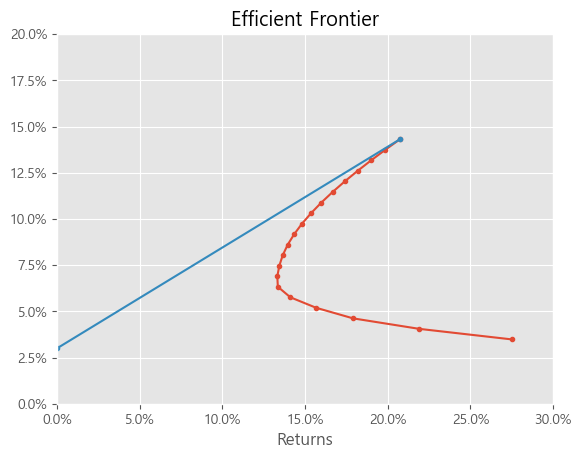

In [15]:

### max sharpe ratio (msr) :
### Sharpe Ratio 극대화하는 가중치 산출하는 함수
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = ((0.0, 1.0),) * n  # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
                        }

    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol

    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x, weights.fun

rf = 0.03
msr_wgt,msr = msr(rf, rtn_ann_ind, cov_ann_ind)

### Sharpe Ratio 가 극대화 되는 포트폴리오의 수익률과 변동성
r_msr = portfolio_return(msr_wgt, rtn_ann_ind)
vol_msr = portfolio_vol(msr_wgt, cov_ann_ind)

### Efficient Frontier와 Max shape ratio, CML 그래프 출력
fig, ax1 = plt.subplots()

# Efficient Frontier
ax1.plot(vols, rets, '.-')
ax1.set_xlabel('Volatility')
ax1.set_xlabel('Returns')
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax1.set_xlim(0,0.3);
ax1.set_ylim(0,0.2);
ax1.set_title('Efficient Frontier');

# Max Sharpe Ratio Point
ax1.plot([0,vol_msr], [rf,r_msr], '.-');


## 다각화의 한계
- 금융위기 등 변동성이 확대되는 시기에 포트폴리오의 상관관계 상승
- 가장 위험분산이 필요한 시기에 위험분산 효과가 급감하는 경향
- 대안적 투자전략의 필요성

In [16]:
### 주식, 채권의 장기 수익률 추이

stdt = '1980-01-01'
ltdt = '2024-12-31'

stk_data = yf.download(['^GSPC','^KS11','AGG'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)  

stk_data = stk_data.tz_localize(None)['Adj Close']
stk_data.columns = ['AGG','SPX','KOSPI']
rtn_w = pk.get_return(stk_data,freq = 'W')

[*********************100%***********************]  3 of 3 completed


In [17]:
rolling_rtn_1yr = (1+rtn_w).rolling(window=52).apply(np.prod) - 1
rolling_rtn_3yr = ((1+rtn_w).rolling(window=52*3).apply(np.prod))**(1/3) - 1
rolling_rtn_5yr = ((1+rtn_w).rolling(window=52*5).apply(np.prod))**(1/5) - 1
rolling_rtn_10yr = ((1+rtn_w).rolling(window=52*10).apply(np.prod))**(1/10) - 1

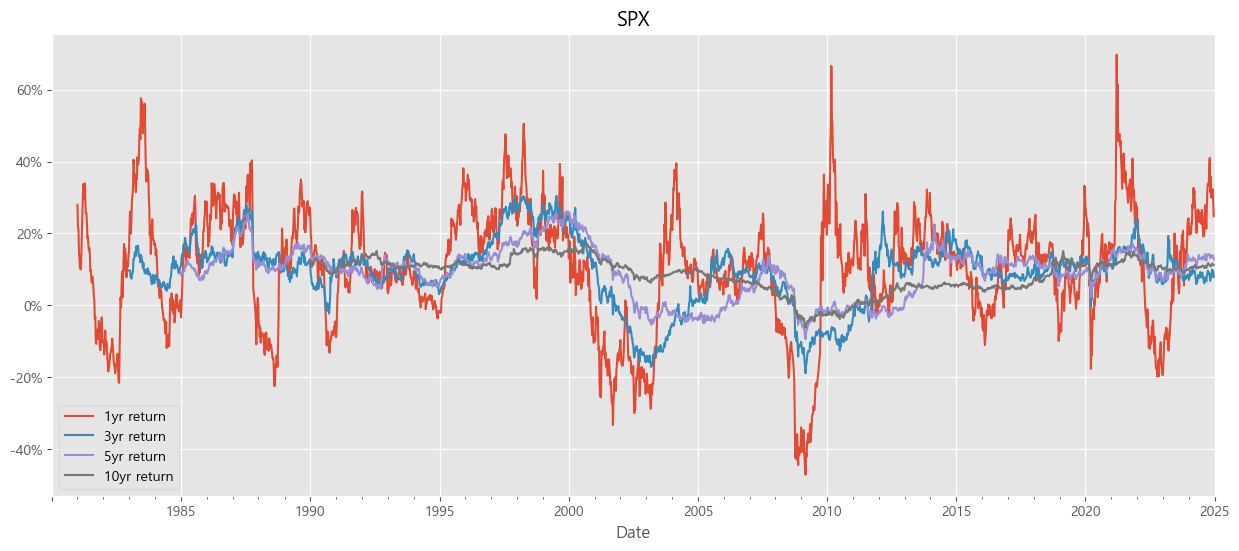

In [18]:
rolling_rtn_1yr['SPX'].plot(figsize=(15,6),label = '1yr return',legend = True);
rolling_rtn_3yr['SPX'].plot(figsize=(15,6),label = '3yr return',legend = True);
rolling_rtn_5yr['SPX'].plot(figsize=(15,6),label = '5yr return',legend = True);
rolling_rtn_10yr['SPX'].plot(figsize=(15,6),label = '10yr return',legend = True);

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
plt.title('SPX');

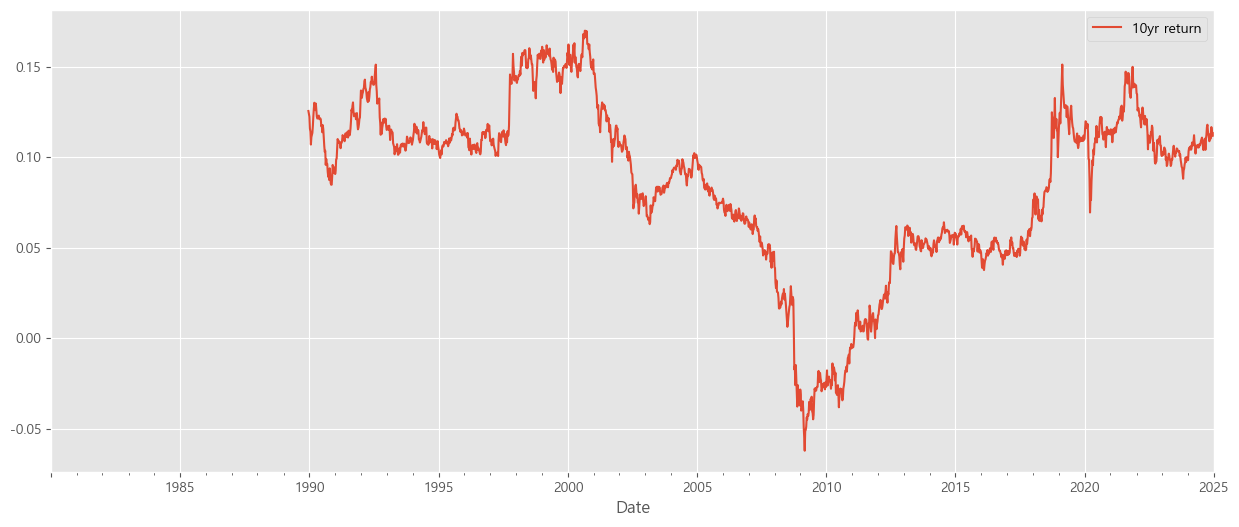

In [19]:
rolling_rtn_10yr['SPX'].plot(figsize=(15,6),label = '10yr return',legend = True);

[*********************100%***********************]  11 of 11 completed


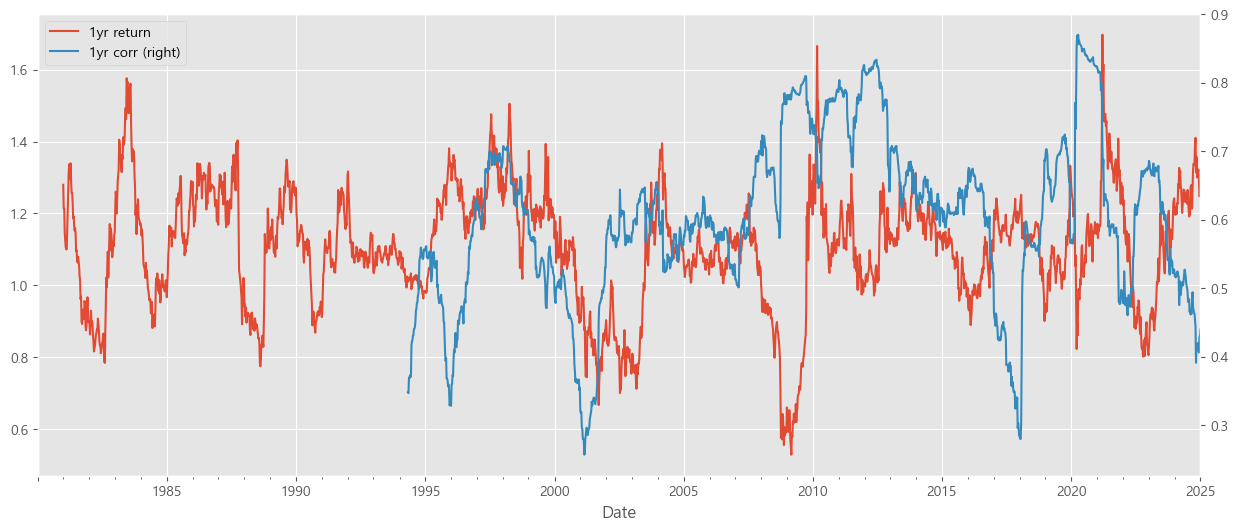

In [20]:
### 수익률과 상관관계 : 수익률 하락시에 상관관계는 상승 => 분산효과 감소하는 경향

stk_data = yf.download(['^GSPC','^SP500-1010','^SP500-15','^SP500-20','^SP500-25','^SP500-30','^SP500-35','^SP500-40','^SP500-45','^SP500-50','^SP500-55'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False) 

stk_data = stk_data.tz_localize(None)['Adj Close']
stk_data.columns = ['SP500','ENG','MAT','IND','CD','CS','HLTH','FIN','TECH','COM','UTIL']
stk_data.head()

rtn_w = pk.get_return(stk_data,freq = 'W')
rtn_w_sec = rtn_w.drop(columns='SP500')

rolling_1yr_rtn = (1+rtn_w['SP500']).rolling(window=52).apply(np.prod)
rolling_1yr_corr = rtn_w_sec.rolling(window=52).corr()
avg_rolling_1yr_corr = rolling_1yr_corr.groupby(level=0).mean().mean(axis=1)
avg_rolling_1yr_corr.head(100)
rolling_1yr_rtn.plot(figsize=(15,6),label = '1yr return',legend = True);
avg_rolling_1yr_corr.plot(secondary_y = True,label = '1yr corr',legend = True);

### 수고하셨습니다